<a href="https://colab.research.google.com/github/MaximeSzymanski/VAE_pytorch/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
# get mnist data
import torchvision
from torchvision import datasets, transforms


In [2]:
# get mnist data and transform to tensor, to the right device.
transform = transforms.Compose([
        transforms.ToTensor(),
        ])

"""device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')"""
device = 'cpu'
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)



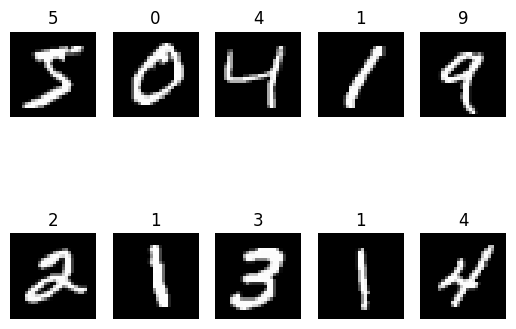

In [3]:
# plot 10 images
import matplotlib.pyplot as plt
import numpy as np
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(mnist_trainset[i][0].numpy().reshape(28, 28), cmap='gray')
    plt.title(mnist_trainset[i][1])
    plt.axis('off')

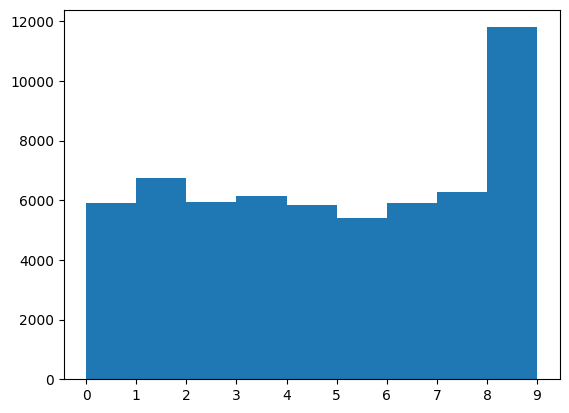

In [4]:
# plot the distribution of labels, with one color for each label
labels = mnist_trainset.targets.numpy()
plt.hist(labels, bins=np.arange(labels.min(), labels.max()+1))
plt.xticks(np.arange(labels.min(), labels.max()+1))
plt.show()

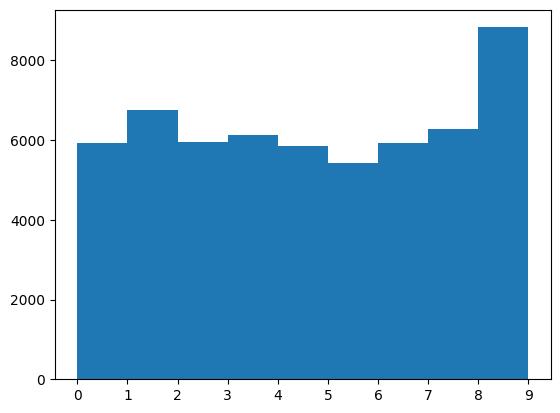

In [5]:
# remove half of the 9s from the training set, to have a more balanced dataset
# we will use this dataset to train the encoder
# get the indices of the 9s
nines = np.where(labels==9)[0]
# shuffle the indices
np.random.shuffle(nines)
# keep only half of the indices
nines = nines[:len(nines)//2]
# remove the 9s from the training set
mnist_trainset.data = torch.cat([mnist_trainset.data[labels!=9], mnist_trainset.data[nines]])
mnist_trainset.targets = torch.cat([mnist_trainset.targets[labels!=9], mnist_trainset.targets[nines]])

# plot the distribution of labels, with one color for each label
labels = mnist_trainset.targets.numpy()
plt.hist(labels, bins=np.arange(labels.min(), labels.max()+1))
plt.xticks(np.arange(labels.min(), labels.max()+1))
plt.show()

In [6]:
# keep only percentage of the training set
percentage = 0.01
mnist_trainset.data = mnist_trainset.data[:int(len(mnist_trainset.data)*percentage)]
mnist_trainset.targets = mnist_trainset.targets[:int(len(mnist_trainset.targets)*percentage)]
mnist_testset.data = mnist_testset.data[:int(len(mnist_testset.data)*percentage)]
mnist_testset.targets = mnist_testset.targets[:int(len(mnist_testset.targets)*percentage)]
print(f"Number of images in the training set: {len(mnist_trainset)}")
print(f"Number of images in the test set: {len(mnist_testset)}")


Number of images in the training set: 570
Number of images in the test set: 100


In [7]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder,self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # relu
        # pooling
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # relu
        # pooling
        # flatten
        self.fc1 = torch.nn.Linear(64*7*7, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, latent_dim)


    def forward(self, x):
        # x: batch_size * 1 * 28 * 28
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        # x: batch_size * 32 * 28 * 28
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        # x: batch_size * 64 * 28 * 28
        # flatten
        x = x.view(-1, 64*7*7)
        # x: batch_size * 64*7*7
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        # x: batch_size * hidden_dim
        x = self.fc2(x)
        # x: batch_size * latent_dim
        return x

In [8]:
encoder = Encoder(1, 128, 2)

In [9]:
print(encoder)

Encoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


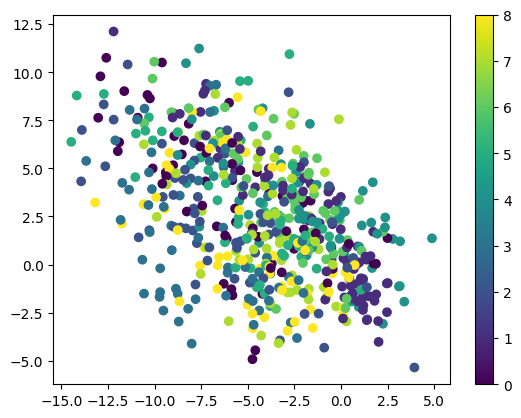

In [10]:
# encode the first 10 images
images = mnist_trainset.data.float().unsqueeze(1)
encoder(images)
# plot the encoded images in 2D
encoded_images = encoder(images).detach().numpy()
plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=mnist_trainset.targets.numpy())
plt.colorbar()
plt.show()

In [30]:
class SamplingLayer(torch.nn.Module):
    def __init__(self):
        super(SamplingLayer, self).__init__()

    def forward(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

class VariationalEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VariationalEncoder, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(8)  # Batch Normalization after the first convolution
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(16)  # Batch Normalization after the second convolution
        self.conv3 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(32)  # Batch Normalization after the third convolution

        self.fc1 = torch.nn.Linear(512, hidden_dim)
        self.mu = torch.nn.Linear(hidden_dim, latent_dim)
        self.logvar = torch.nn.Linear(hidden_dim, latent_dim)
        self.sampling = SamplingLayer()
        # init logvar to 0
        self.logvar.weight.data.fill_(0)
        self.logvar.bias.data.fill_(0)

    def forward(self, x):
        original_x = x
        x = self.conv1(x)
        x = self.bn1(x)  # Apply Batch Normalization
        x = torch.nn.functional.leaky_relu(x, 0.2)
        x = self.conv2(x)
        x = self.bn2(x)  # Apply Batch Normalization
        x = torch.nn.functional.leaky_relu(x, 0.2)
        x = self.conv3(x)
        x = self.bn3(x)  # Apply Batch Normalization
        x = torch.nn.functional.leaky_relu(x, 0.2)

        x = torch.nn.Flatten(start_dim=1)(x)
        # x: batch_size * 64*7*7
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        # x: batch_size * hidden_dim
        mu = self.mu(x)
        sigma = self.logvar(x)
        z = self.sampling(mu, sigma)
        # print the shape
        """print(f'original_x: {original_x.shape}')
        print(f'mu: {mu.shape}')
        print(f'sigma: {sigma.shape}')
        print(f'z: {z.shape}')"""

        # x: batch_size * latent_dim
        return z, mu, sigma, original_x

class VariationalDecoder(torch.nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(VariationalDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.fc1 = torch.nn.Linear(latent_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 3 * 3 * 32)

        # Transpose Convolutional layers
        self.t_conv1 = torch.nn.ConvTranspose2d(32, 16, kernel_size=7, stride=2, padding=0)
        self.bn1 = torch.nn.BatchNorm2d(16)  # Batch Normalization after the first transposed convolution
        self.t_conv2 = torch.nn.ConvTranspose2d(16, 8, kernel_size=7, stride=2, padding=0)
        self.bn2 = torch.nn.BatchNorm2d(8)  # Batch Normalization after the second transposed convolution
        self.t_conv3 = torch.nn.ConvTranspose2d(8, 1, kernel_size=4, stride=1, padding=1)



    def forward(self, x):
        batch_size = x.size(0)
        x = self.fc1(x)
        x = torch.nn.functional.leaky_relu(x, 0.2)
        x = self.fc2(x)
        x = torch.nn.functional.leaky_relu(x, 0.2)
        x = torch.nn.Unflatten(1, (32, 3, 3))(x)
        x = self.t_conv1(x)
        x = self.bn1(x)  # Apply Batch Normalization
        x = torch.nn.functional.leaky_relu(x, 0.2)
        x = self.t_conv2(x)
        x = self.bn2(x)  # Apply Batch Normalization
        x = torch.nn.functional.leaky_relu(x, 0.2)
        x = self.t_conv3(x)
        x = torch.nn.functional.sigmoid(x)

        return x



In [31]:
class VariationalAutoEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VariationalAutoEncoder, self).__init__()
        self.encoder = VariationalEncoder(input_dim, hidden_dim, latent_dim)
        self.decoder = VariationalDecoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        z, mu, sigma, original_x = self.encoder(x)
        x = self.decoder(z)
        return x, mu, sigma, original_x

In [32]:
def KL_loss(mu, sigma):
    return -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())

def reconstruction_loss(original_x, x):


    return torch.nn.functional.binary_cross_entropy(x, original_x, reduction='sum')

def loss_function(x, original_x, mu, sigma,k1=1,k2=1e-4):

    return k1 *reconstruction_loss(original_x, x) + k2 * KL_loss(mu, sigma)

In [33]:

variational_autoencoder = VariationalAutoEncoder(1, 128, 64)
variational_autoencoder.to(device)
print(variational_autoencoder.encoder)

VariationalEncoder(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (mu): Linear(in_features=128, out_features=64, bias=True)
  (logvar): Linear(in_features=128, out_features=64, bias=True)
  (sampling): SamplingLayer()
)


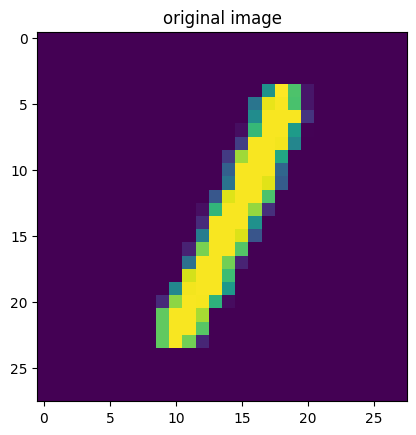

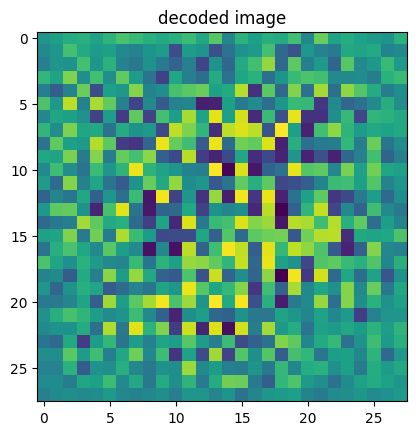

In [34]:
# encode the first 10 images
images = mnist_trainset.data[1].float().unsqueeze(0).unsqueeze(1)
images = images.to(device)

encoded,_,_,_= variational_autoencoder.encoder(images)
decoded = variational_autoencoder.decoder(encoded)

# plot the original image, and the decoded images
plt.imshow(images[0, 0].cpu().detach().numpy())
# add title
plt.title("original image")
plt.show()
encoded_images = encoded.cpu().detach().numpy()
plt.imshow(decoded[0, 0].cpu().detach().numpy())
plt.title("decoded image")
plt.show()



In [35]:
print(variational_autoencoder)

VariationalAutoEncoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=512, out_features=128, bias=True)
    (mu): Linear(in_features=128, out_features=64, bias=True)
    (logvar): Linear(in_features=128, out_features=64, bias=True)
    (sampling): SamplingLayer()
  )
  (decoder): VariationalDecoder(
    (fc1): Linear(in_features=64, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=288, bias=True)
    (t_conv1): ConvTranspose2d(32, 16, kernel_siz

In [36]:
batch_size = 64
lr = 1e-3
epochs = 10
optimizer = torch.optim.Adam(variational_autoencoder.parameters(), lr=lr)


In [37]:

# take inly 10 images
#mnist_trainset.data = mnist_trainset.data[:nb_image_to_overfit]
#mnist_trainset.targets = mnist_trainset.targets[:nb_image_to_overfit]

# shuffle the data and the targets in the same way
indices = torch.randperm(len(mnist_trainset.data))
mnist_trainset.data = mnist_trainset.data[indices]
mnist_trainset.targets = mnist_trainset.targets[indices]

mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)


<ipython-input-38-ba146f6228d2>:14: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.scatterplot(x=encoded_data_2d[:, 0], y=encoded_data_2d[:, 1], hue=mnist_trainset.targets.numpy(), legend='full', palette=sns.color_palette("hls", 10))


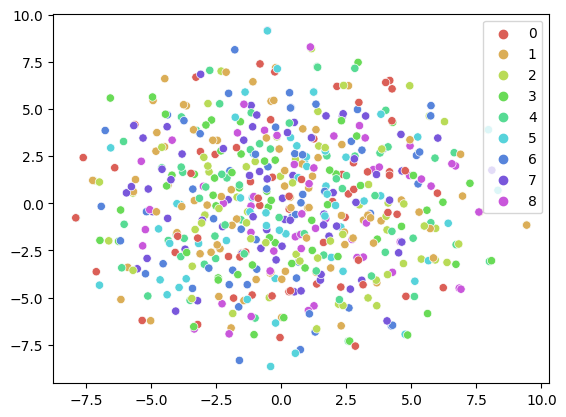

In [38]:
# check clusters using t-sne
from sklearn.manifold import TSNE
import seaborn as sns
with torch.no_grad():
    images = mnist_trainset.data.float().unsqueeze(1)
    images = images.to(device)
    encoded = variational_autoencoder.encoder(images)
    decoded = variational_autoencoder.decoder(encoded[0])

    # Plot the encoded images in 2D and use contrasting colors
    encoded_images = encoded[0].cpu().detach().numpy()

encoded_data_2d = TSNE(n_components=2).fit_transform(encoded_images)
sns.scatterplot(x=encoded_data_2d[:, 0], y=encoded_data_2d[:, 1], hue=mnist_trainset.targets.numpy(), legend='full', palette=sns.color_palette("hls", 10))
plt.show()

In [39]:
def train(epochs):
    for epoch in range(epochs):
        epoch_loss = 0

        for i, (images, _) in enumerate(mnist_trainloader):
            # plot the first image of the first batch

            # check if images is full of 0
            images = images.float()
            # count number of non 0 in the tensor


            images = images.to(device)
            x, mu, sigma, original_x = variational_autoencoder(images)
            original_x = original_x.detach()
            loss = loss_function(x, original_x, mu, sigma)

            epoch_loss += loss.mean().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch: {epoch+1}, Loss: {epoch_loss/len(mnist_trainloader.dataset)}')


In [40]:
train(10)

Epoch: 1, Loss: 547.8575075383771
Epoch: 2, Loss: 383.40371779057017
Epoch: 3, Loss: 307.59612801535087
Epoch: 4, Loss: 262.9950743558114
Epoch: 5, Loss: 235.18926295230264
Epoch: 6, Loss: 214.43987801535087
Epoch: 7, Loss: 196.83552631578948
Epoch: 8, Loss: 181.5719812225877
Epoch: 9, Loss: 169.79570826480264
Epoch: 10, Loss: 157.6660430372807


torch.Size([570, 28, 28])


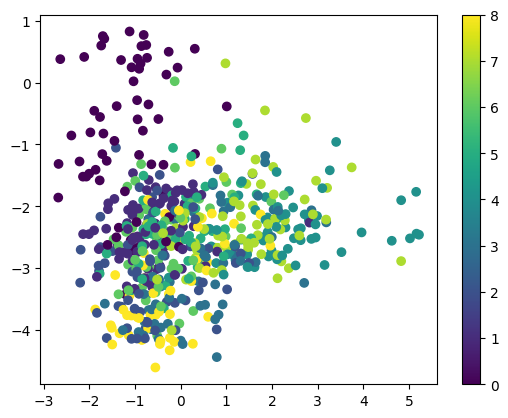

In [41]:
# take all images from the train set
with torch.no_grad():
  # encode the first 10 images
    print(mnist_trainset.data.shape)
    images = mnist_trainset.data.float().unsqueeze(1)
    images = images.to(device)
    # plot the encoded images in 2D

    encoded_images, _ , _ ,_  = variational_autoencoder.encoder(images)
    encoded_images = encoded_images.cpu().detach().numpy()
    plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=mnist_trainset.targets.numpy())
    plt.colorbar()
    plt.show()


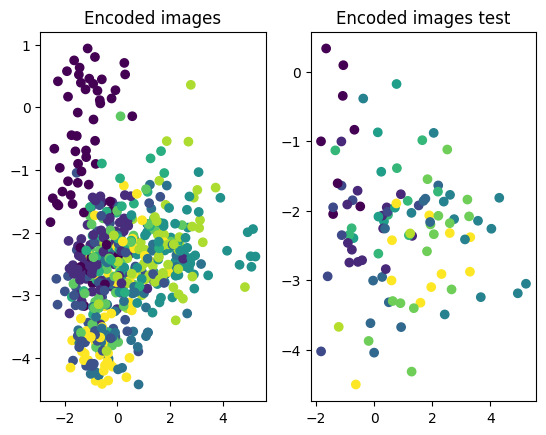

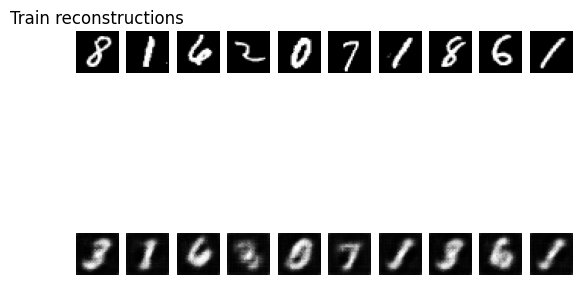

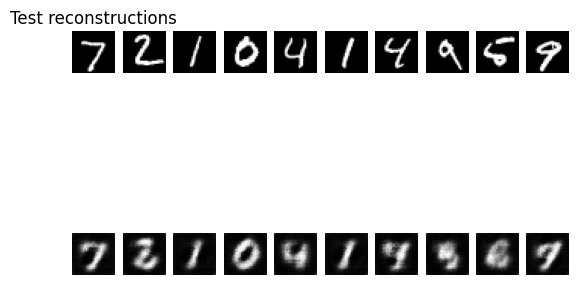

In [42]:
import torch
import matplotlib.pyplot as plt

# Take 10 images from the train set
with torch.no_grad():
    images = mnist_trainset.data.float().unsqueeze(1)
    images = images.to(device)
    encoded = variational_autoencoder.encoder(images)

    # Plot the encoded images in 2D and use contrasting colors
    encoded_images = encoded[0].cpu().detach().numpy()
    c = mnist_trainset.targets.numpy()
    f, ax_arr = plt.subplots(1, 2)
    ax_arr[0].scatter(encoded_images[:, 0], encoded_images[:, 1], c=c)
    ax_arr[0].set_title('Encoded images')

    images_test = mnist_testset.data.float().unsqueeze(1)
    images_test = images_test.to(device)
    encoded = variational_autoencoder.encoder(images_test)

    # Plot the encoded images in 2D and use contrasting colors
    encoded_images = encoded[0].cpu().detach().numpy()
    c = mnist_testset.targets.numpy()

    ax_arr[1].scatter(encoded_images[:, 0], encoded_images[:, 1], c=c)
    ax_arr[1].set_title('Encoded images test')

    # Plot the decoded images in a 2 by 5 grid, with the original images on top of each decoded image
    f, axarr = plt.subplots(2, 10)

    # Get the first 10 images
    random_images_train = mnist_trainset.data[:10].float().unsqueeze(1)
    random_images_train = random_images_train.to(device)
    # Encode the whole images
    encoded_train, _, _, _ = variational_autoencoder.encoder(random_images_train)

    decoded_train = variational_autoencoder.decoder(encoded_train)
    # Decode the whole images and plot them
    axarr[0, 0].set_title('Train reconstructions')

    for i in range(10):
        # Remove the axis ticks
        axarr[0, i].axis('off')
        axarr[1, i].axis('off')
        # name it train
        # Plot the original images in black and white
        axarr[0, i].imshow(random_images_train[i, 0].cpu().detach().numpy(), cmap='gray')

        axarr[1, i].imshow(decoded_train[i, 0].cpu().detach().numpy(), cmap='gray')


    # Do the same for the test set
    random_images_test = mnist_testset.data[:10].float().unsqueeze(1)
    random_images_test = random_images_test.to(device)
    # Encode the whole test images
    encoded_test, _, _, _ = variational_autoencoder.encoder(random_images_test)

    # Decode the test images
    decoded_test = variational_autoencoder.decoder(encoded_test)

    # Plot the decoded test images
    f, axarr = plt.subplots(2, 10)
    axarr[0, 0].set_title('Test reconstructions')

    for i in range(10):
        # Remove the axis ticks
        axarr[0, i].axis('off')
        axarr[1, i].axis('off')

        # Plot the original images in black and white
        axarr[0, i].imshow(random_images_test[i, 0].cpu().detach().numpy(), cmap='gray')

        axarr[1, i].imshow(decoded_test[i, 0].cpu().detach().numpy(), cmap='gray')
    plt.show()




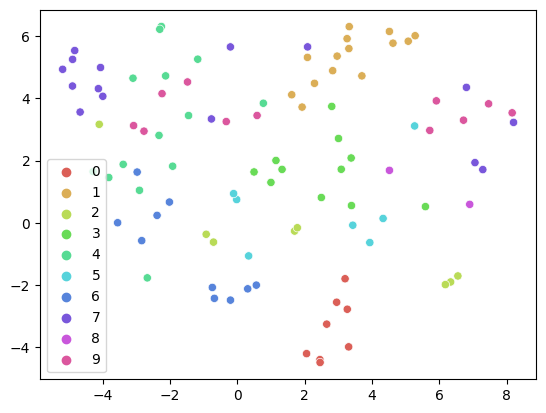

In [43]:
# check clusters using t-sne
from sklearn.manifold import TSNE
import seaborn as sns
with torch.no_grad():
    images = mnist_testset.data.float().unsqueeze(1)
    images = images.to(device)
    encoded = variational_autoencoder.encoder(images)
    decoded = variational_autoencoder.decoder(encoded[0])

    # Plot the encoded images in 2D and use contrasting colors
    encoded_images = encoded[0].cpu().detach().numpy()

encoded_data_2d = TSNE(n_components=2).fit_transform(encoded_images)
sns.scatterplot(x=encoded_data_2d[:, 0], y=encoded_data_2d[:, 1], hue=mnist_testset.targets.numpy(), legend='full', palette=sns.color_palette("hls", 10))
plt.show()

<ipython-input-44-b0f8350dbb9c>:12: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.scatterplot(x=encoded_data_2d[:, 0], y=encoded_data_2d[:, 1], hue=mnist_trainset.targets.numpy(), legend='full', palette=sns.color_palette("hls", 10))


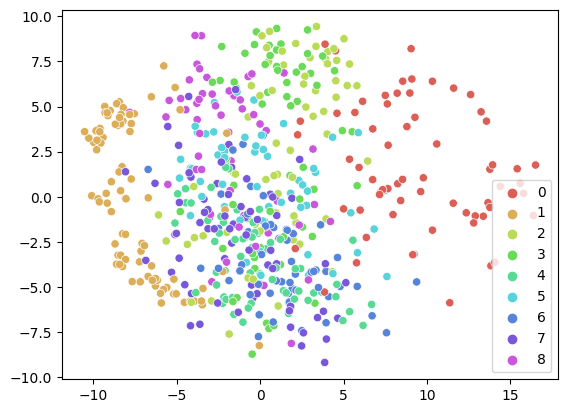

In [44]:
# do same with PCA
from sklearn.decomposition import PCA
with torch.no_grad():
    images = mnist_trainset.data.float().unsqueeze(1)
    images = images.to(device)
    encoded = variational_autoencoder.encoder(images)

    # Plot the encoded images in 2D and use contrasting colors
    encoded_images = encoded[0].cpu().detach().numpy()

encoded_data_2d = PCA(n_components=2).fit_transform(encoded_images)
sns.scatterplot(x=encoded_data_2d[:, 0], y=encoded_data_2d[:, 1], hue=mnist_trainset.targets.numpy(), legend='full', palette=sns.color_palette("hls", 10))
plt.show()

In [45]:
!pip install -q optuna

In [46]:
# lets use optuna to find the best hyperparameters
import optuna
from optuna.trial import TrialState

def define_model(trial):
    # create the Variational Autoencoder
    hidden_dim = 256
    latent_size = trial.suggest_int('latent_size', 2, 200)

    model = VariationalAutoEncoder(input_dim=1,hidden_dim=hidden_dim, latent_dim=latent_size)
    return model



def objective(trial):
    # Generate the model.
    model = define_model(trial).to(device)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam"])

    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    k1 =1
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
    k2 = trial.suggest_float('k2', 1e-5, 1)
    # Training of the model.
    for epoch in range(20):
        epoch_loss = 0
        model.train()
        for images, _ in mnist_trainloader:
            images = images.to(device)
            x, mu, sigma, original_x = model(images)
            original_x = original_x.detach()
            loss = loss_function(x, original_x, mu, sigma,k1=k1,k2=k2)

            epoch_loss += loss.mean().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        trial.report(epoch_loss, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return epoch_loss/len(mnist_trainloader.dataset)

In [47]:

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-10-30 19:45:18,961] A new study created in memory with name: no-name-f29279fb-4064-4d91-8cbc-01d400d2f6ae
[I 2023-10-30 19:45:34,545] Trial 0 finished with value: 361.47841282894734 and parameters: {'latent_size': 136, 'optimizer': 'Adam', 'lr': 9.170768124830765e-05, 'k2': 0.6313583377139034}. Best is trial 0 with value: 361.47841282894734.
[I 2023-10-30 19:45:48,393] Trial 1 finished with value: 109.17449372944078 and parameters: {'latent_size': 17, 'optimizer': 'Adam', 'lr': 0.003359195747486008, 'k2': 0.5063766221128445}. Best is trial 0 with value: 361.47841282894734.
[I 2023-10-30 19:45:56,663] Trial 2 finished with value: 127.27124109100878 and parameters: {'latent_size': 162, 'optimizer': 'Adam', 'lr': 0.0020288864695451178, 'k2': 0.3965898357953925}. Best is trial 0 with value: 361.47841282894734.
[I 2023-10-30 19:46:04,892] Trial 3 finished with value: 179.16793277138157 and parameters: {'latent_size': 86, 'optimizer': 'Adam', 'lr': 0.02863826812462466, 'k2': 0.512582

KeyboardInterrupt: ignored